## average of G2 

In [2]:
# Import Standard Python Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Import pyLM Libraries
from pyLM import *
from pyLM.units import *
from pySTDLM import *
from pySTDLM import PostProcessing

In [3]:
# file_path = "output/24052024/gal_cme_ode_gae2_gia0_rep50_delta1.lm"
# file_path = "output/21082024/gal_cme_ode_gae2_gia0_rep100_delta1.lm"
# output_path = "output/21082024"
# file_name = "gal_cme_ode_gae2_gia0_rep100_delta1.lm"
output_path = "output/23082024"
file_name = "gal_cme_ode_gae11.1_gia0_rep50_delta0.5.lm"
file_path = output_path + "/" + file_name 

# Load the data handle

traj = PostProcessing.openLMFile(file_path)

species_list = PostProcessing.getSpecies(traj)
# print(len(species_list))
# print(species_list)
reps = file_path.split('rep')[1].split('_')[0]
gae = file_path.split('gae')[1].split('_gia')[0]
print(f"Extracted GAE value: {gae}", 'mM')
print(f"Extracted reps value: {reps}")

# Reorganize the species list based on the given criteria
species_list = sorted(species_list, key=lambda x: (not x[0].startswith('DG'), not (x[0].startswith('R') or x[0] == 'reporter_rna'), not (x[0].startswith('G') and not x[0].startswith('GA')or x[0] == 'reporter'), x[0].startswith('GA')))
GA_species_list = ['GAI']
general_species_list = [species for species in species_list if species[0] not in GA_species_list]

print(general_species_list)
print(GA_species_list)
print(len(GA_species_list)+ len(general_species_list))



Extracted GAE value: 11.1 mM
Extracted reps value: 50
[['DG1'], ['DG1_G4d'], ['DG1_G4d_G80d'], ['DG2'], ['DG2_G4d'], ['DG2_G4d_G80d'], ['DG3'], ['DG3_G4d'], ['DG3_G4d_G80d'], ['DGrep'], ['DGrep_G4d'], ['DGrep_G4d_G80d'], ['DG80'], ['DG80_G4d'], ['DG80_G4d_G80d'], ['R1'], ['R2'], ['R3'], ['R4'], ['reporter_rna'], ['R80'], ['G1'], ['G2'], ['G3'], ['G3i'], ['G4'], ['G4d'], ['reporter'], ['G80'], ['G80C'], ['G80d'], ['G80Cd'], ['G80G3i'], ['G2GAI'], ['G2GAE'], ['G1GAI']]
['GAI']
37


## Overall View of every species trajectory

In [4]:
avg_list_general = []
var_list_general = []
time_list_general = []

avg_list_GA = []
var_list_GA = []
time_list_GA = []

for species in general_species_list:
    avg, var, times = PostProcessing.getAvgVarTrace(traj, species[0])
    avg_list_general.append(avg)
    var_list_general.append(np.sqrt(var))
    time_list_general.append(times)

if len(GA_species_list) == 1:
    species = GA_species_list[0]
    avg, var, times = PostProcessing.getAvgVarTrace(traj, species)
    count2concentration = 4.65e-8  #molecule/cell to mM
    avg_list_GA.append(avg*count2concentration)
    var_list_GA.append(np.sqrt(var)*count2concentration)
    time_list_GA.append(times)
else:
    for species in GA_species_list:
        avg, var, times = PostProcessing.getAvgVarTrace(traj, species[0])
        count2concentration = 4.65e-8  #molecule/cell to mM
        avg_list_GA.append(avg*count2concentration)
        var_list_GA.append(np.sqrt(var)*count2concentration)
        time_list_GA.append(times)
        
        

# Create a dictionary to store data for each species
species_data = {}
for species, avg, std, times in zip(general_species_list + GA_species_list, 
                                    avg_list_general + avg_list_GA, 
                                    var_list_general + var_list_GA, 
                                    time_list_general + time_list_GA):
    species_name = species[0] if isinstance(species, list) else species
    species_data[species_name] = {'avg': avg, 'std': std, 'times': times}


show gene expression level in a desired order.

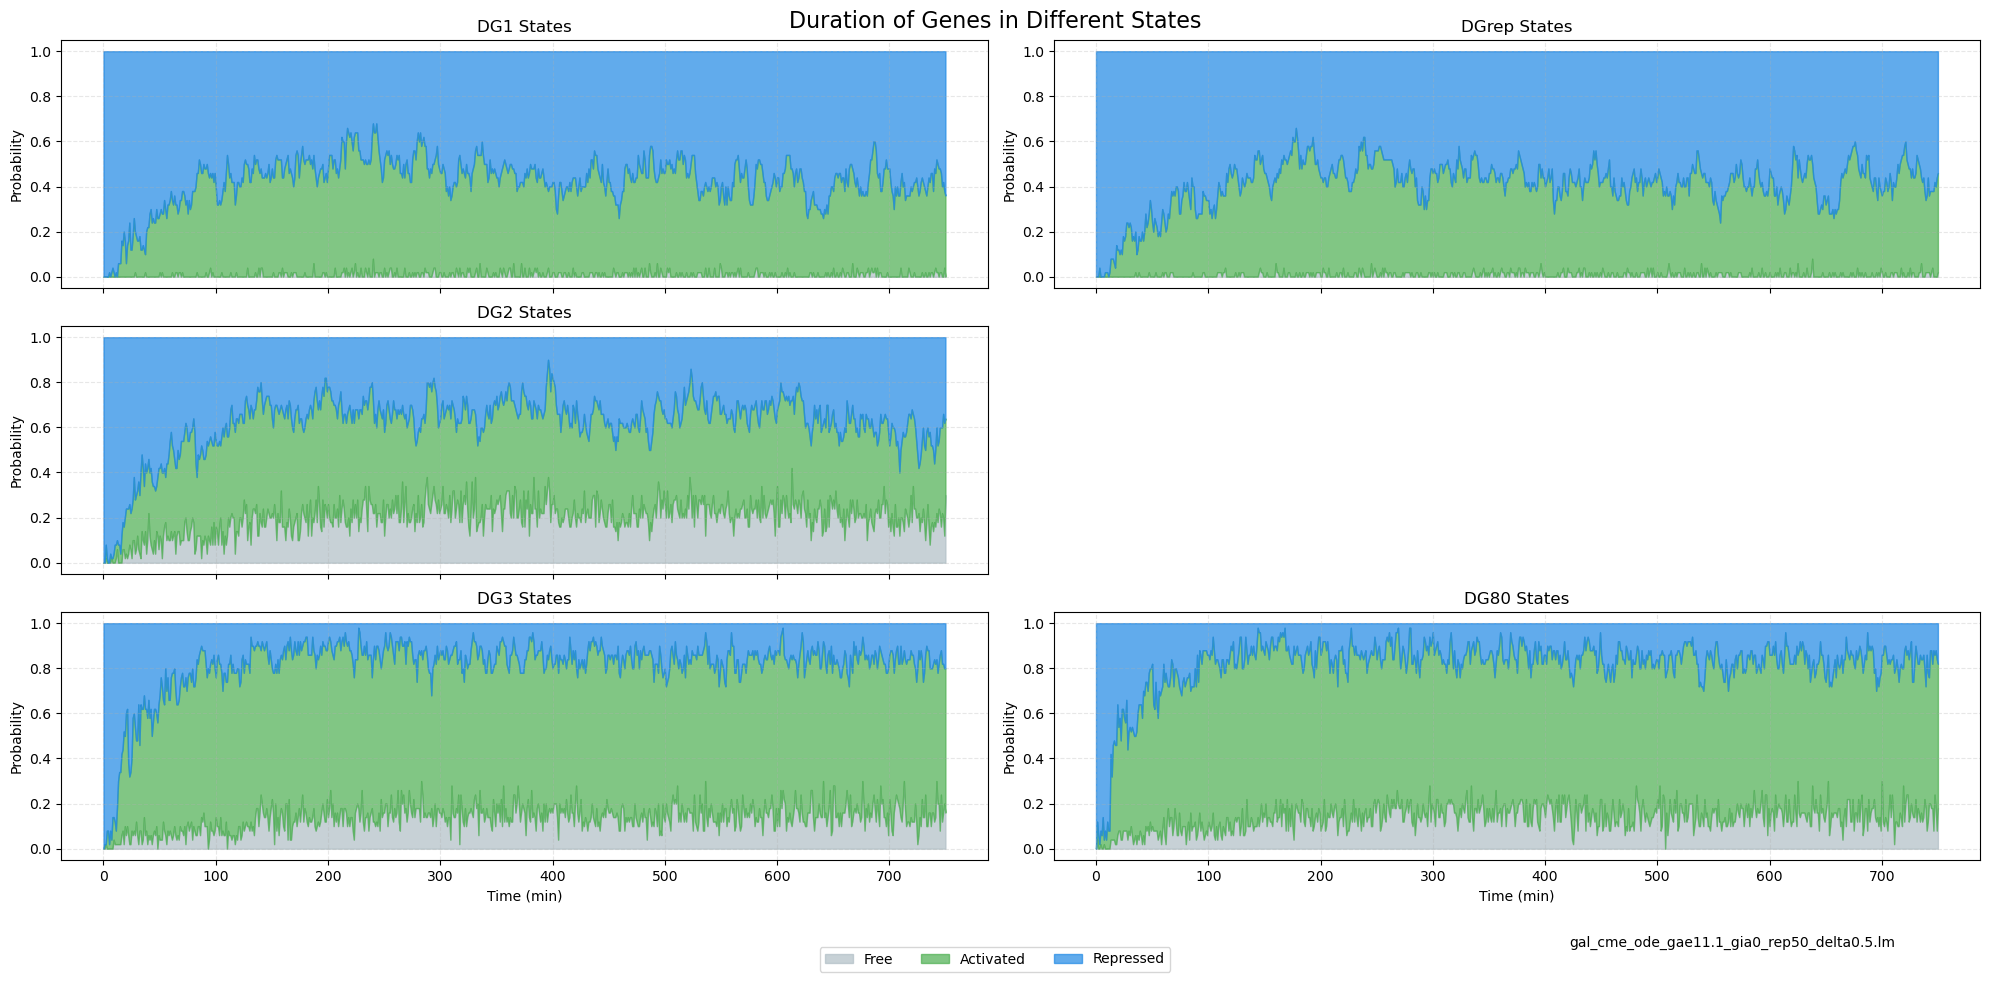

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the genes and their states
genes = [['DG1', 'DGrep'], ['DG2'], ['DG3', 'DG80']]
states = ['', '_G4d', '_G4d_G80d']

# Create a figure with subplots for each gene
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
fig.suptitle('Duration of Genes in Different States', fontsize=16, y=0.95)

# Colors for different states
colors = ['#B0BEC5', '#4CAF50', '#1E88E5']

# Create a list to store legend handles
legend_handles = []

for row, gene_row in enumerate(genes):
    for col, gene in enumerate(gene_row):
        ax = axs[row, col]
        bottom = np.zeros_like(times)
        
        for j, state in enumerate(states):
            species_name = f'{gene}{state}'
            if species_name in species_data:
                values = species_data[species_name]['avg']
                handle = ax.fill_between(times, bottom, bottom + values, alpha=0.7, color=colors[j])
                bottom += values
                
                # Only add to legend_handles for the first gene (to avoid duplicates)
                if row == 0 and col == 0 and j == 0:
                    legend_handles = [handle]
                elif row == 0 and col == 0:
                    legend_handles.append(handle)
        
        ax.set_ylabel('Probability')
        ax.set_title(f'{gene} States')
        ax.grid(True, linestyle='--', alpha=0.3)

    # Hide unused subplot
    if len(gene_row) == 1:
        axs[row, 1].set_visible(False)

# Set x-label for bottom subplots
for ax in axs[-1, :]:
    ax.set_xlabel('Time (min)')

# Add a single legend for all subplots
fig.legend(legend_handles, ['Free', 'Activated', 'Repressed'], 
           loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3)

# Add the file_name as a string in the bottom right of the figure
plt.gcf().text(0.95, 0.01, file_name, fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.92)  # Adjust these values to make room for the title and legend
plt.show()

# Save the figure
fig.savefig(output_path + f'/gene_states_duration_gae{gae}_rep{reps}.png', dpi=300, bbox_inches='tight')

show species trajectory in a desired order.

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

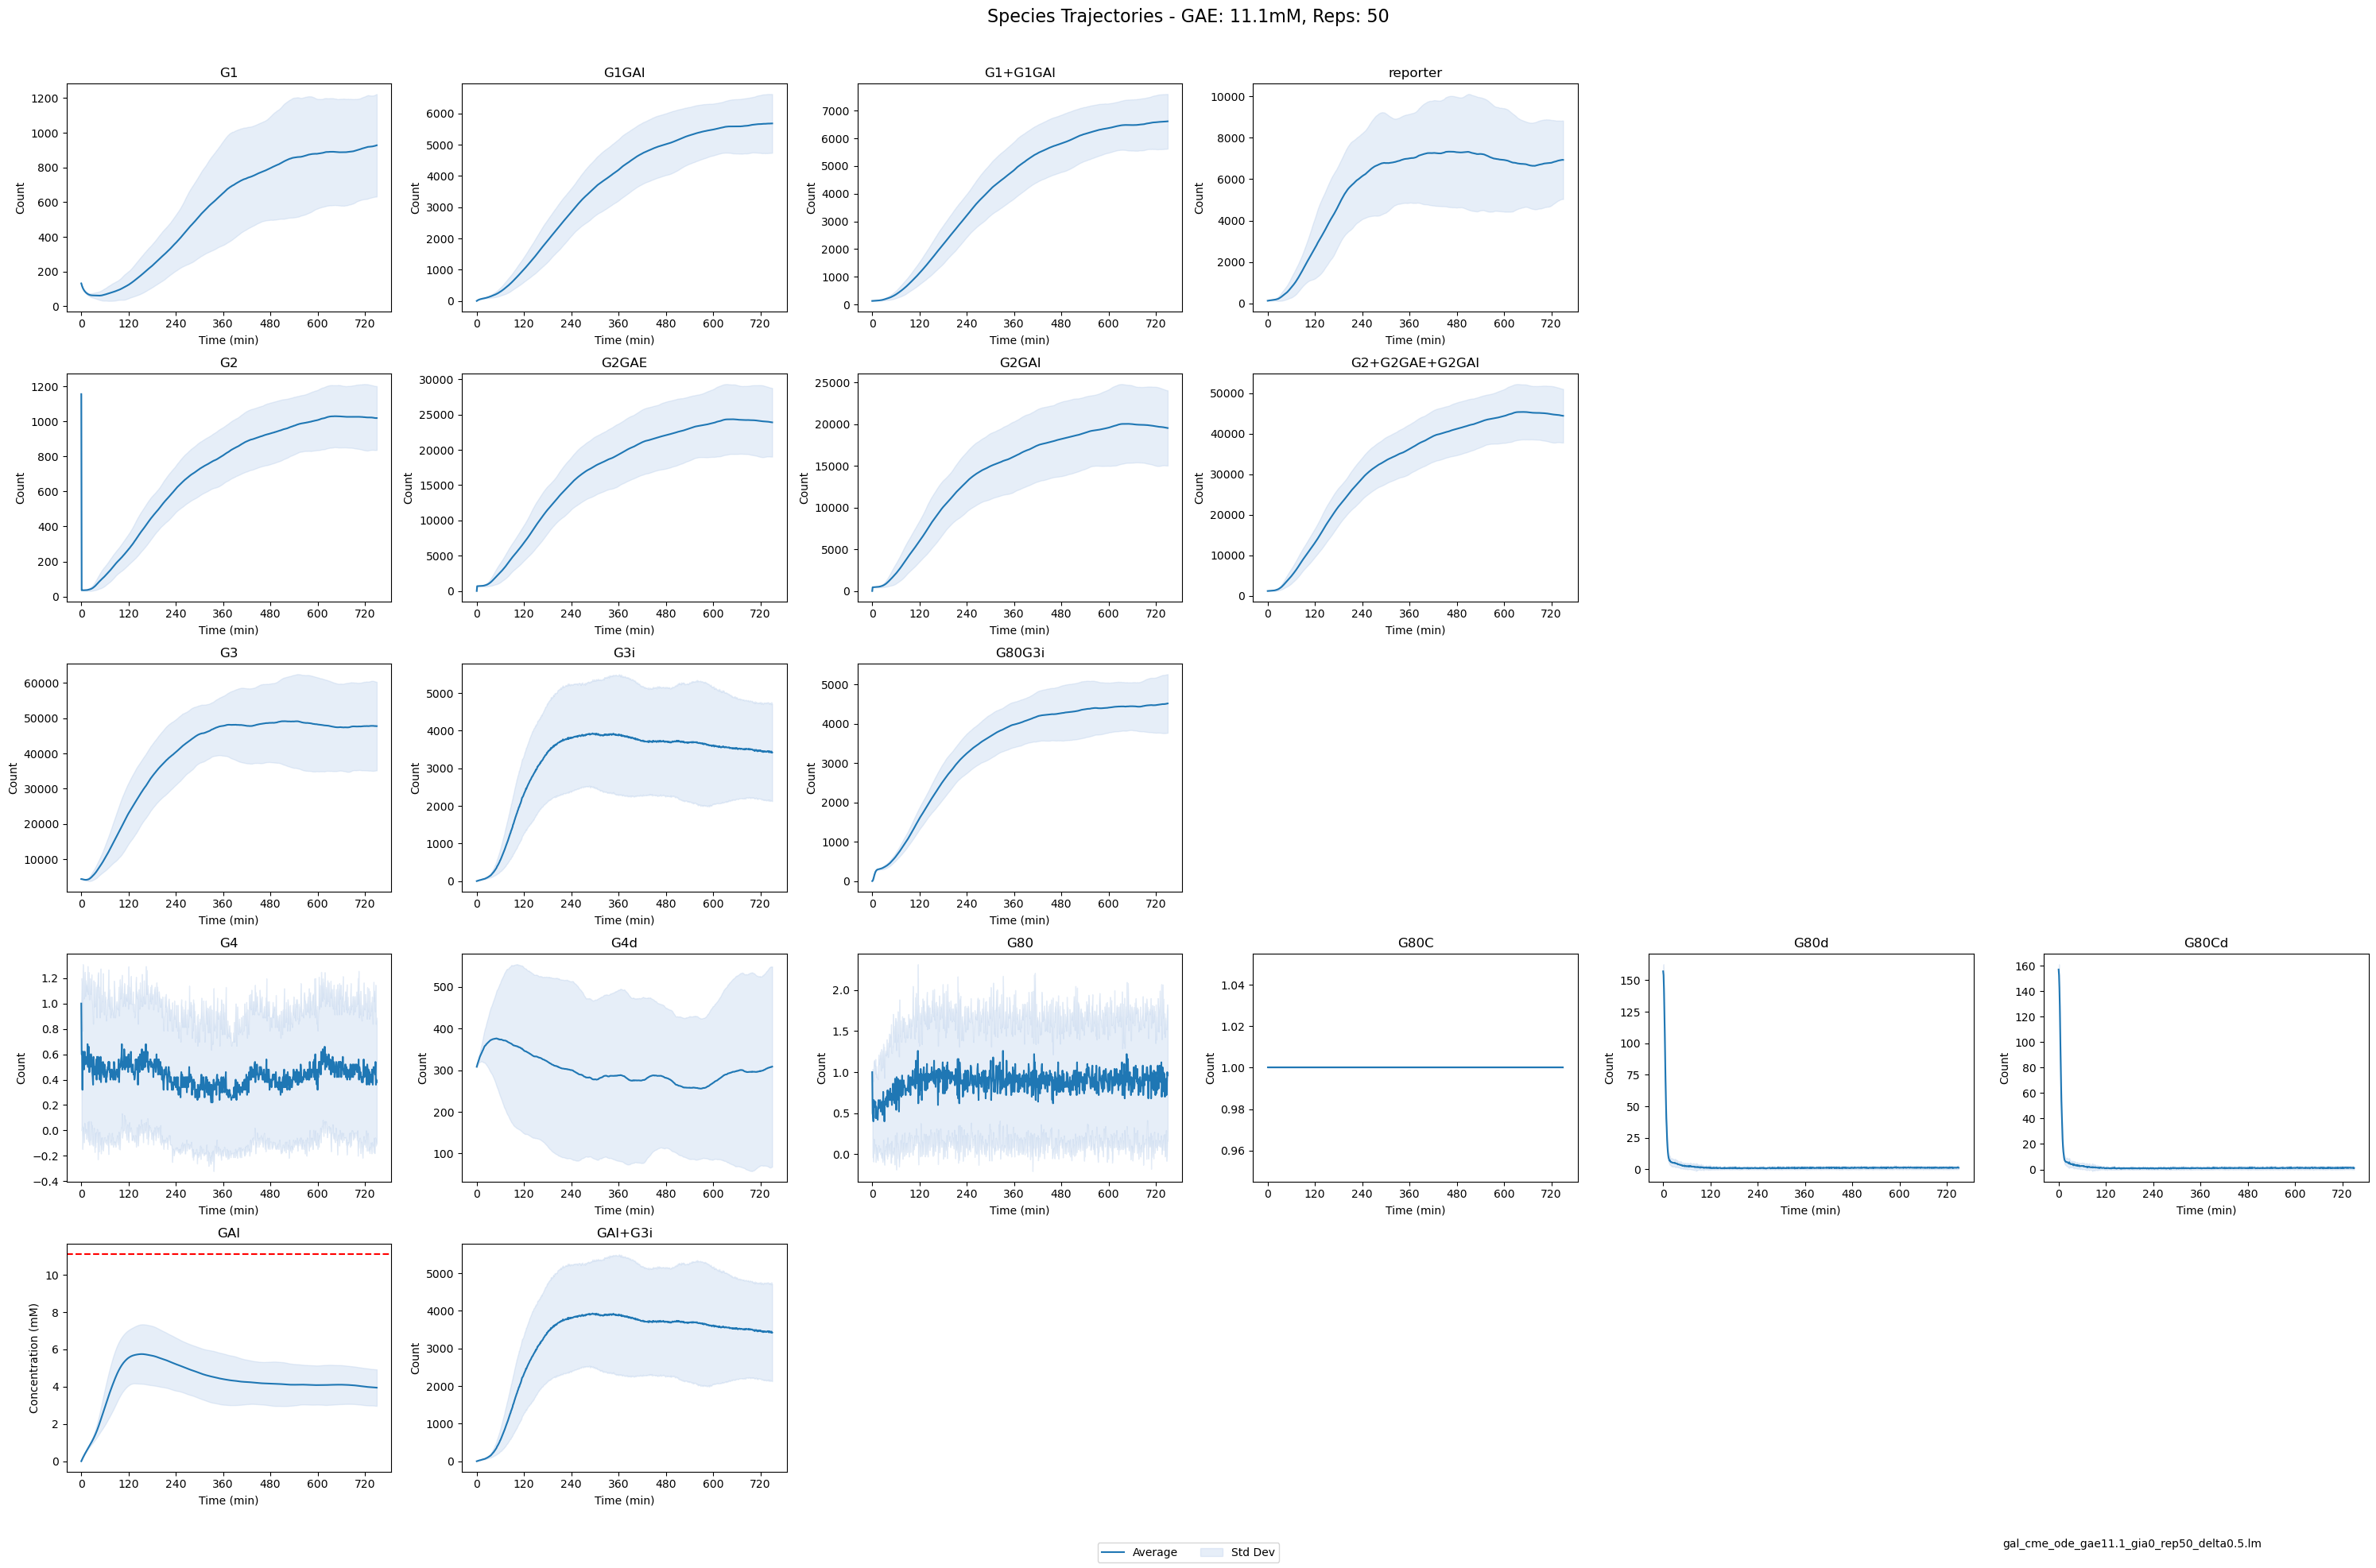

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Define the desired order of species
species_order = [
    ['G1', 'G1GAI', 'G1+G1GAI', 'reporter'],
    ['G2', 'G2GAE', 'G2GAI', 'G2+G2GAE+G2GAI'],
    ['G3', 'G3i','G80G3i'],
    ['G4', 'G4d', 'G80','G80C', 'G80d','G80Cd' ],
    ['GAI','GAI+G3i']
]

# Define colors for average and standard deviation
avg_color = '#1f77b4'  # Dark Blue
std_color = '#aec7e8'  # Light Blue

# Check if names in species_order are in species_data, if not, create sum species_data
for row in species_order:
    for species_name in row:
        if species_name not in species_data:
            if '+' in species_name:
                sub_species = species_name.split('+')
                # print(sub_species)
                if all(sub in species_data for sub in sub_species):
                    avg_sum = np.sum([species_data[sub]['avg'] for sub in sub_species], axis=0)
                    std_sum = np.sqrt(np.sum([species_data[sub]['std']**2 for sub in sub_species], axis=0))
                    times = species_data[sub_species[0]]['times']
                    species_data[species_name] = {'avg': avg_sum, 'std': std_sum, 'times': times}
            else:
                print(f"{species_name} not in species_data, please check")
# Prepare plot layout
nrows = len(species_order)
ncols = max(len(row) for row in species_order)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))

# Plot data in the specified order
for row, species_row in enumerate(species_order):
    for col, species_name in enumerate(species_row):
        ax = axs[row, col]
        if species_name in species_data:
            data = species_data[species_name]
          
            ax.plot(data['times'], data['avg'], c=avg_color)
            ax.fill_between(data['times'], data['avg'] - data['std'], data['avg'] + data['std'], 
                            color=std_color, alpha=0.3)
            
            if species_name == 'GAI':
                ax.axhline(y=float(gae), color='r', linestyle='--')
                ax.set(ylabel='Concentration (mM)')
            else:
                ax.set(ylabel='Count')
            
            ax.set(title=species_name, xlabel='Time (min)', 
                   xticks=np.arange(0, max(data['times']), 120))
        else:
            ax.set_visible(False)

    # Hide unused subplots in this row
    for col in range(len(species_row), ncols):
        axs[row, col].set_visible(False)

# Adjust layout and add title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f"Species Trajectories - GAE: {gae}mM, Reps: {reps}", fontsize=16)

# Add a single legend at the bottom
fig.legend(labels=["Average", "Std Dev"], loc='lower center', ncol=2, fontsize=10)

# Add the file_name as a string in the bottom right of the figure
plt.gcf().text(0.95, 0.01, file_name, fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# Save the figure
plt.savefig(output_path + f'/ordered_species_trajectories_gae{gae}_rep{reps}.png', dpi=300)
plt.show()

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

the following code is depreciated, it is to show all species in the order of species_list

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming avg_list, var_list, time_list, and species_list are already defined

# # Prepare plot layout
# nplots = len(general_species_list) + len(GA_species_list)
# ncols = 4
# nrows = int(np.ceil(nplots / ncols))

# # Arguments for the axes
# axargs = dict(xlabel='Time (min)', ylabel='Count', xticks=np.arange(0, max(time_list_general[0]), 120))  # Decreased x-axis label frequency
# axargs_GA = dict(xlabel='Time (min)', ylabel='Concentration (mM)', xticks=np.arange(0, max(time_list_GA[0]), 120))  # Decreased x-axis label frequency
# # Create figure and subplots
# fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 3 * nrows))

# # Adjust layout to make space for the suptitle
# fig.subplots_adjust(top=0.90)

# # Add a title to the figure without overlapping with subplots
# fig.suptitle(f"All Species Trajectories - GAE: {gae}mM, Reps: {reps}", y=0.95)

# axs = axs.ravel()
# colors = sns.color_palette()

# # Plot data
# for i, (species, avg, std, times) in enumerate(zip(general_species_list, avg_list_general, var_list_general, time_list_general)):
#     ax = axs[i]
#     ax.plot(times, avg, c=colors[0])
#     ax.fill_between(times, avg - std, avg + std, color=colors[0], alpha=0.3)
#     ax.set(title=species[0], **axargs)
    
# for i, (species, avg, std, times) in enumerate(zip(GA_species_list, avg_list_GA, var_list_GA, time_list_GA)):
#     ax = axs[i + len(general_species_list)]
#     if species == 'GAI':
#         ax.plot(times, avg, c=colors[0])
#         ax.fill_between(times, avg - std, avg + std, color=colors[0], alpha=0.3)
#         ax.axhline(y=float(gae), color='r', linestyle='--')
#     else:
#         ax.plot(times, avg, c=colors[0])
#         ax.fill_between(times, avg - std, avg + std, color=colors[0], alpha=0.3)
#     ax.set(title=species if len(GA_species_list) == 1 else species[0], **axargs_GA)



# # Remove empty subplots
# for i, ax in enumerate(axs):
#     if i >= nplots:
#         ax.remove()

# # Tight layout to adjust subplots spacing
# fig.tight_layout(rect=[0, 0, 1, 0.95])

# # Add a single legend at the end
# fig.legend(labels=["Average", "Std Dev"], loc='lower center', ncol=2, fontsize=10)

# # Save the figure
# plt.savefig(output_path + f'/all_species_trajectories_gae{gae}_rep{reps}.png', dpi=300)
# plt.show()

## G2 related trajectory

In [ ]:
# Find the index of G2 in the species list
g2_index = species_list.index(['G2'])

# Extract G2 data
g2_avg = avg_list_general[g2_index]
g2_std = var_list_general[g2_index]
g2_times = time_list_general[g2_index]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(g2_times, g2_avg, label='G2 Average')
plt.fill_between(g2_times, g2_avg - g2_std, g2_avg + g2_std, alpha=0.3)

plt.xlabel('Time')
plt.ylabel('G2 Count')
plt.title(f'Average G2 Species Count Over Time with {gae}mM GAE')
plt.ylim(0, 3600)  # Set y-axis limits to 0-3600
plt.legend()
plt.grid(True)


# save the figure
output_path = file_path.split("/")

plt.savefig(f'{output_path[0]}/{output_path[1]}/avgg2_gal_cme_ode_gae{gae}_gia0_rep{reps}_delta0.5.png')
plt.show()


## Number of G2 distribution in 700 min

In [ ]:
# This needs to be modified when processing different data
file_path = "output/22082024/gal_cme_ode_gae0.055_gia0_rep500_delta1.lm"
reps = 500

# here we start to draw the distribution of G2 at 700 min
times = PostProcessing.getTimesteps(file_path)
g2_rep1 =PostProcessing.getSpecieTrace(file_path,specie='G2',replicate=1)
import scipy.stats as stats

# Find the index closest to time = 700
target_time = 700
closest_index = min(range(len(times)), key=lambda i: abs(times[i] - target_time))

# Initialize a list to store G2 values at t=700 for all replicates
g2_values_at_700 = []

# Loop through all replicates
for rep in range(1, reps + 1):
    g2_trace = PostProcessing.getSpecieTrace(file_path, specie='G2', replicate=rep)
    g2_values_at_700.append(g2_trace[closest_index])

# Create a kernel density estimation
kde = stats.gaussian_kde(g2_values_at_700)

# Create points on which to evaluate the distribution
x_range = np.linspace(min(g2_values_at_700), max(g2_values_at_700), 100)



# Print some statistics
# Calculate statistics
mean_g2 = np.mean(g2_values_at_700)
median_g2 = np.median(g2_values_at_700)
std_g2 = np.std(g2_values_at_700)

# Plot the continuous distribution
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde(x_range))
plt.xlabel('G2 Count')
plt.ylabel('Density')
plt.title(f'Distribution of G2 at t={times[closest_index]:.2f}')
plt.grid(True)

# Add statistics to the plot
plt.text(0.05, 0.95, f"Mean: {mean_g2:.2f}\nMedian: {median_g2:.2f}\nStd Dev: {std_g2:.2f}", 
         transform=plt.gca().transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Print statistics
print(f"Mean G2 count at t={times[closest_index]:.2f}: {mean_g2:.2f}")
print(f"Median G2 count at t={times[closest_index]:.2f}: {median_g2:.2f}")
print(f"Standard deviation of G2 count at t={times[closest_index]:.2f}: {std_g2:.2f}")



## G2 family

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

# Limit the time steps to the first 120
time_limit = g2_times[:61]
g2_avg_limit = g2_avg[:61]
g2gai_avg_limit = g2gai_avg[:61]
g2gae_avg_limit = g2gae_avg[:61]

# Calculate final counts
final_count = g2_avg_limit + g2gai_avg_limit + g2gae_avg_limit

# Plot the filled area for G2GAE first
ax.fill_between(time_limit, g2_avg_limit + g2gai_avg_limit, g2_avg_limit + g2gai_avg_limit + g2gae_avg_limit, color='orange', alpha=0.5, label='G2GAE in ODE')

# Then plot G2GAI
ax.fill_between(time_limit, g2_avg_limit, g2_avg_limit + g2gai_avg_limit, color='red', alpha=0.5, label='G2GAI in ODE')

# Finally, plot G2 in ODE
ax.fill_between(time_limit, 0, g2_avg_limit, color='blue', alpha=0.5, label='G2 in ODE')

# Add final count to the plot
# Add final count to the plot
plt.gcf().text(0.95, 0.65, f'Final Count: {int(final_count[-1])}' ,
               verticalalignment='bottom', horizontalalignment='left', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize the plot
ax.set_xlabel('Time(min)')
ax.set_ylabel('Counts')
ax.set_title('Transporter(G2) counts in CME ODE')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()